In [1]:
import numpy as np 
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from category_encoders.binary import BinaryEncoder

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Dataset

In [3]:
df_trans = pd.read_csv('kaggle_data/credit_card_transactions-ibm_v2.csv').sample(n=1000000, random_state=42)

In [14]:
df = df_trans

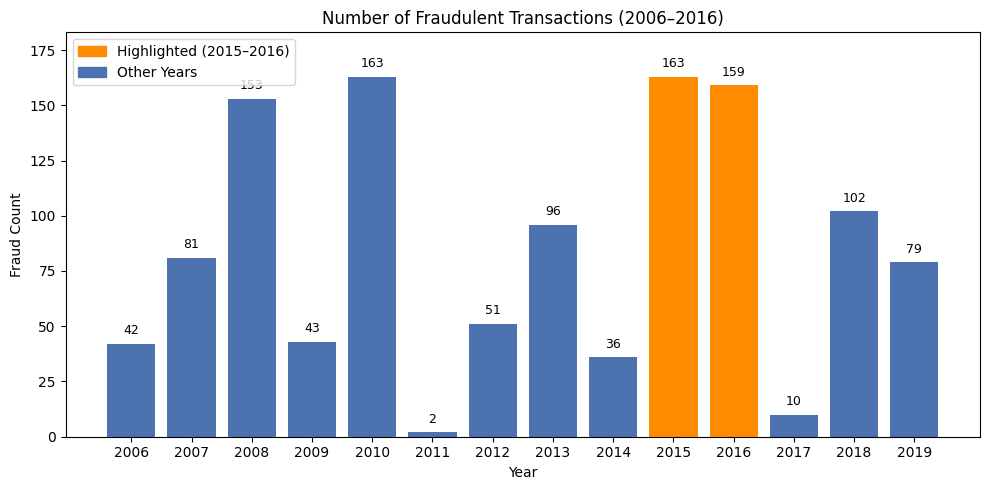

In [5]:
# EDA Fraud Label Transaction
fraud_trans = df_trans[df_trans['Is Fraud?']=='Yes']

year_counts = fraud_trans['Year'].value_counts().sort_index()  
year_counts = year_counts[year_counts.index >= 2006]
fraud_by_year = year_counts.to_dict()

years = sorted(fraud_by_year.keys())
counts = [fraud_by_year[y] for y in years]

colors = ['#FF8C00' if y in [2015, 2016] else '#4C72B0' for y in years]

plt.figure(figsize=(10, 5))
bars = plt.bar(years, counts, color=colors)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 3, str(count),
             ha='center', va='bottom', fontsize=9)

plt.title('Number of Fraudulent Transactions (2006–2016)')
plt.xlabel('Year')
plt.ylabel('Fraud Count')
plt.xticks(years)
plt.ylim(0, max(counts) + 20)

# Chú thích
plt.legend(handles=[
    plt.Rectangle((0,0),1,1, color='#FF8C00', label='Highlighted (2015–2016)'),
    plt.Rectangle((0,0),1,1, color='#4C72B0', label='Other Years')],
    loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
df = df[df['Year'].isin([2015,2016])]
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
13223840,1084,0,2015,9,20,14:58,$6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,NaN,No
5845532,490,5,2015,11,28,13:45,$92.67,Chip Transaction,4722913068560264812,Pompano Beach,FL,33063.0,5411,NaN,No
1775807,142,0,2016,8,20,06:28,$40.11,Chip Transaction,-1263263438141072419,Woodinville,WA,98077.0,5912,NaN,No
14643407,1201,0,2015,9,20,01:52,$69.70,Chip Transaction,-4259710328928763776,Montgomery,AL,36106.0,7349,NaN,No
20428972,1666,1,2016,8,9,10:51,$1.19,Chip Transaction,6666504894937430109,Spanish Fork,UT,84660.0,5499,NaN,No


# EDA Fraud Label Transactions

In [7]:
fraud_trans['Merchant City'].value_counts().head()

Merchant City
ONLINE            804
Rome              184
Algiers            22
Port au Prince     15
Strasburg          15
Name: count, dtype: int64

In [ ]:
df["Amount"]=df["Amount"].str.replace("$","").astype(float)
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]
df = df.drop(['Time'],axis=1)
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Extract day of the week and map it to its name
days = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
df['Day of Week'] = df['Date'].dt.dayofweek.map(days)

df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)
df["Merchant"] = df["Merchant Name"].astype(str) + "_" + df["Merchant City"].astype(str)

In [9]:
import pandas as pd

fraud_df = df[df['Is Fraud?'] == 1].copy()  # Giả sử 'Is Fraud?' = 1 là fraud

# 1. Top 5 user có nhiều fraud nhất
user_fraud = fraud_df['card_id'].value_counts().head(10)
user_total = df['card_id'].value_counts()[user_fraud.index]

user_stats = pd.DataFrame({
    'Total Transactions': user_total,
    'Fraud Transactions': user_fraud,
    'Fraud Rate': user_fraud / user_total
}).sort_values('Fraud Transactions', ascending=False)

# 2. Top 5 merchant có nhiều fraud nhất
merchant_fraud = fraud_df['Merchant'].value_counts().head(10)
merchant_total = df['Merchant'].value_counts()[merchant_fraud.index]

merchant_stats = pd.DataFrame({
    'Total Transactions': merchant_total,
    'Fraud Transactions': merchant_fraud,
    'Fraud Rate': merchant_fraud / merchant_total
}).sort_values('Fraud Transactions', ascending=False)

print("Top 10 Users with Most Fraud Transactions:")
display(user_stats)
print("\nTop 10 Merchants with Most Fraud Transactions:")
display(merchant_stats)

Top 10 Users with Most Fraud Transactions:


,Total Transactions,Fraud Transactions,Fraud Rate
card_id,,,
1487_5,32,4,0.125000
360_0,48,3,0.062500
1685_4,33,3,0.090909
1731_2,9,3,0.333333
758_0,14,3,0.214286
929_0,16,3,0.187500
658_0,27,3,0.111111
49_0,15,3,0.200000
456_0,50,3,0.060000



Top 10 Merchants with Most Fraud Transactions:


,Total Transactions,Fraud Transactions,Fraud Rate
Merchant,,,
-4282466774399734331_ONLINE,38,38,1.000000
1913477460590765860_ONLINE,15,15,1.000000
4872340518840476610_ONLINE,11,11,1.000000
-3220758452254689706_ONLINE,9,9,1.000000
-1908131910424232363_ONLINE,6,6,1.000000
6098563624419731578_ONLINE,5,5,1.000000
-2042049018365856408_ONLINE,211,5,0.023697
3635551857898739641_ONLINE,5,5,1.000000
-245178307025547046_ONLINE,5,5,1.000000


# Training Process

In [17]:
df.head()

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute,Date,Day of Week,card_id,Merchant
13223840,1084,0,2015,9,20,6.76,Chip Transaction,-7837310524365334241,Littleton,CO,80122.0,5300,NaN,0,14,58,2015-09-20,Sun,1084_0,-7837310524365334241_Littleton
5845532,490,5,2015,11,28,92.67,Chip Transaction,4722913068560264812,Pompano Beach,FL,33063.0,5411,NaN,0,13,45,2015-11-28,Sat,490_5,4722913068560264812_Pompano Beach
1775807,142,0,2016,8,20,40.11,Chip Transaction,-1263263438141072419,Woodinville,WA,98077.0,5912,NaN,0,06,28,2016-08-20,Sat,142_0,-1263263438141072419_Woodinville
14643407,1201,0,2015,9,20,69.70,Chip Transaction,-4259710328928763776,Montgomery,AL,36106.0,7349,NaN,0,01,52,2015-09-20,Sun,1201_0,-4259710328928763776_Montgomery
20428972,1666,1,2016,8,9,1.19,Chip Transaction,6666504894937430109,Spanish Fork,UT,84660.0,5499,NaN,0,10,51,2016-08-09,Tue,1666_1,6666504894937430109_Spanish Fork


## Preprocess and Feature Selection 

In [18]:
orig_df = df
columns_to_select = ['Year', 'Day of Week', 'Hour', 'Amount', 'Use Chip', 'Merchant Name', 'Merchant City' ,'MCC', 'Is Fraud?']
df = orig_df[columns_to_select]
df['isOnline'] = np.where(df['Merchant City'] == 'ONLINE', 1, 0)
df = df.drop(['Merchant City'],axis=1)

orig_df = orig_df.drop(["User","Card"],axis=1)

In [19]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

def clean(df):
    # Convert data type
    df['Hour'] = df['Hour'].astype('float')
    
    # Scale the "Amount" column
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])
   
    # Binary encoding for categorical variables
    cat_col = ['Use Chip', 'Day of Week']
    for col in cat_col:
        if col in df.columns:
            be = ce.BinaryEncoder(drop_invariant=False)
            enc_df = pd.DataFrame(be.fit_transform(df[col]), dtype='int8')
            df = pd.concat([df, enc_df], axis=1)
            df.drop([col], axis=1, inplace=True)
    
    for col in df.columns:
        df[col] = df[col].astype(float)
        
    return df

# Create the pipeline
preprocessing_pipeline = Pipeline([
    ('cleaning', FunctionTransformer(clean, validate=False)), 
], verbose=True)

df_transformed = preprocessing_pipeline.fit_transform(df)

[Pipeline] .......... (step 1 of 1) Processing cleaning, total=   0.4s


## Split Train-Test Data

In [20]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = df_transformed.drop(columns=['Is Fraud?'])
y = df_transformed['Is Fraud?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1613)
train_idx = X_train.index
test_idx = X_test.index

In [21]:
orig_df.rename(columns={"Merchant": "merchant_node", "card_id": "client_node", "Is Fraud?":"fraud_label"}, inplace=True)
columns_to_select = ['Year', 'Hour', 'Amount', 'Day of Week', 'Use Chip', 'merchant_node', 'MCC', 'client_node','fraud_label']

graph_df = orig_df[columns_to_select]

In [22]:
graph_df["Day of Week"]=LabelEncoder().fit_transform(graph_df["Day of Week"])
graph_df["Use Chip"]=LabelEncoder().fit_transform(graph_df["Use Chip"])

In [23]:
train_data = graph_df.loc[train_idx]
inductive_data = graph_df.loc[test_idx]

## Build Train Graph

In [24]:
from inductiveGRL.graphconstruction import GraphConstruction

transaction_node_data = train_data.drop("client_node", axis=1).drop("merchant_node", axis=1).drop("fraud_label", axis=1)
client_node_data = pd.DataFrame([1]*len(train_data.client_node.unique())).set_index(train_data.client_node.unique())
merchant_node_data = pd.DataFrame([1]*len(train_data.merchant_node.unique())).set_index(train_data.merchant_node.unique())

nodes = {"client":train_data.client_node, "merchant":train_data.merchant_node, "transaction":train_data.index}
edges = [zip(train_data.client_node, train_data.index),zip(train_data.merchant_node, train_data.index)]
features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}

graph = GraphConstruction(nodes, edges, features)
S = graph.get_stellargraph()
print(S.info())

StellarGraph: Undirected multigraph
 Nodes: 146912, Edges: 223996

 Node types:
  transaction: [111998]
    Features: float32 vector, length 6
    Edge types: transaction-default->client, transaction-default->merchant
  merchant: [30855]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction
  client: [4059]
    Features: float32 vector, length 1
    Edge types: client-default->transaction

 Edge types:
    merchant-default->transaction: [111998]
        Weights: all 1 (default)
        Features: none
    client-default->transaction: [111998]
        Weights: all 1 (default)
        Features: none


In [25]:
from inductiveGRL.hinsage import HinSAGE_Representation_Learner

embedding_size = 32
add_additional_data = True
#GraphSAGE parameters
num_samples = [2,64]
embedding_node_type = "transaction"

hinsage = HinSAGE_Representation_Learner(embedding_size, num_samples, embedding_node_type)
trained_hinsage_model, train_emb = hinsage.train_hinsage(S, list(train_data.index), train_data['fraud_label'], batch_size=5, epochs=10)

Epoch 1/10
17920/17920 [==============================] - 50s 3ms/step - loss: 0.0203 - val_loss: 0.0166
Epoch 2/10
17920/17920 [==============================] - 48s 3ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 3/10
17920/17920 [==============================] - 50s 3ms/step - loss: 0.0158 - val_loss: 0.0163
Epoch 4/10
17920/17920 [==============================] - 52s 3ms/step - loss: 0.0157 - val_loss: 0.0161
Epoch 5/10
17920/17920 [==============================] - 50s 3ms/step - loss: 0.0156 - val_loss: 0.0162
Epoch 6/10
17920/17920 [==============================] - 50s 3ms/step - loss: 0.0155 - val_loss: 0.0163
Epoch 7/10
17920/17920 [==============================] - 51s 3ms/step - loss: 0.0155 - val_loss: 0.0157
Epoch 8/10
17920/17920 [==============================] - 51s 3ms/step - loss: 0.0154 - val_loss: 0.0158
Epoch 9/10
17920/17920 [==============================] - 50s 3ms/step - loss: 0.0153 - val_loss: 0.0159
Epoch 10/10
22400/22400 [==============================

## Build Test Graph

In [26]:
pd.options.mode.chained_assignment = None

train_data['index'] = train_data.index
inductive_data['index'] = inductive_data.index
inductive_graph_data = pd.concat((train_data,inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

transaction_node_data = inductive_graph_data.drop("client_node", axis=1).drop("merchant_node", axis=1).drop("fraud_label", axis=1)
client_node_data = pd.DataFrame([1]*len(inductive_graph_data.client_node.unique())).set_index(inductive_graph_data.client_node.unique())
merchant_node_data = pd.DataFrame([1]*len(inductive_graph_data.merchant_node.unique())).set_index(inductive_graph_data.merchant_node.unique())

nodes = {"client":inductive_graph_data.client_node, "merchant":inductive_graph_data.merchant_node, "transaction":inductive_graph_data.index}
edges = [zip(inductive_graph_data.client_node, inductive_graph_data.index),zip(inductive_graph_data.merchant_node, inductive_graph_data.index)]
features = {"transaction": transaction_node_data, 'client': client_node_data, 'merchant': merchant_node_data}
 
graph = GraphConstruction(nodes, edges, features)
S_combined = graph.get_stellargraph()
print(S_combined.info())

StellarGraph: Undirected multigraph
 Nodes: 178452, Edges: 279996

 Node types:
  transaction: [139998]
    Features: float32 vector, length 6
    Edge types: transaction-default->client, transaction-default->merchant
  merchant: [34386]
    Features: float32 vector, length 1
    Edge types: merchant-default->transaction
  client: [4068]
    Features: float32 vector, length 1
    Edge types: client-default->transaction

 Edge types:
    merchant-default->transaction: [139998]
        Weights: all 1 (default)
        Features: none
    client-default->transaction: [139998]
        Weights: all 1 (default)
        Features: none


In [ ]:
from stellargraph.mapper import HinSAGENodeGenerator

test_generator = HinSAGENodeGenerator(
    S_combined,
    batch_size=5,  
    num_samples=[2, 64],  
    head_node_type="transaction"
).flow(inductive_data.index)  

try:
    test_predictions = trained_hinsage_model.predict(test_generator)
except ValueError:
    test_predictions = []
    for batch in test_generator:
        if isinstance(batch, (list, tuple)):
            batch = batch[0] 
        preds = trained_hinsage_model.predict(batch)
        test_predictions.extend(preds.squeeze())
    test_predictions = np.array(test_predictions)

inductive_emb = pd.DataFrame(np.vstack(test_predictions), index=inductive_data.index)


## Finetune Parameter

In [ ]:
# Dimensionality Reduction
from sklearn.decomposition import PCA

for i in range(2,9):
    print('Dimension: ' + str(i))

    pca = PCA(n_components=i)
    train_emb_pca = pd.DataFrame(pca.fit_transform(train_emb), index=train_emb.index)
    test_emb_pca = pd.DataFrame(pca.transform(inductive_emb), index=inductive_emb.index)

    concat_train_emb= pd.merge(train_emb_pca, X_train, left_index=True, right_index=True)
    concat_inductive_emb = pd.merge(test_emb_pca, X_test, left_index=True, right_index=True)
    concat_train_emb.columns = concat_train_emb.columns.astype(str)
    concat_inductive_emb.columns = concat_inductive_emb.columns.astype(str)

    xgb_classifier = XGBClassifier(n_estimators=100, 
                                use_label_encoder=False, 
                                eval_metric='logloss', 
                                random_state=42)

    xgb_classifier.fit(concat_train_emb, y_train)

    y_pred_fusion = xgb_classifier.predict(concat_inductive_emb)
    print(confusion_matrix(y_test, y_pred_fusion))

Dimension: 2
[[27934     1]
 [   18    47]]
Dimension: 3
[[27934     1]
 [   26    39]]
Dimension: 4
[[27933     2]
 [   25    40]]
Dimension: 5
[[27934     1]
 [   25    40]]
Dimension: 6
[[27935     0]
 [   26    39]]
Dimension: 7
[[27932     3]
 [   30    35]]
Dimension: 8
[[27935     0]
 [   30    35]]



# Test and Analyze the result

In [ ]:
# Fusion model 
pca = PCA(n_components=2)
train_emb_pca = pd.DataFrame(pca.fit_transform(train_emb), index=train_emb.index)
test_emb_pca = pd.DataFrame(pca.transform(inductive_emb), index=inductive_emb.index)

concat_train_emb= pd.merge(train_emb_pca, X_train, left_index=True, right_index=True)
concat_inductive_emb = pd.merge(test_emb_pca, X_test, left_index=True, right_index=True)
concat_train_emb.columns = concat_train_emb.columns.astype(str)
concat_inductive_emb.columns = concat_inductive_emb.columns.astype(str)

xgb_classifier = XGBClassifier(n_estimators=100, 
                            use_label_encoder=False,  
                            eval_metric='logloss',  
                            random_state=42)

xgb_classifier.fit(concat_train_emb, y_train)

y_pred_xgb_hinsage = xgb_classifier.predict(concat_inductive_emb)
cm_fusion = confusion_matrix(y_test, y_pred_xgb_hinsage)
print(cm_fusion)


[[27934     1]
 [   18    47]]



In [ ]:
# Tabular only model
xgb_classifier = XGBClassifier(n_estimators=100, 
                            use_label_encoder=False,  
                            eval_metric='logloss',   
                            random_state=42)

xgb_classifier.fit(X_train, y_train)

y_pred_xgb = xgb_classifier.predict(X_test)
cm_tabular = confusion_matrix(y_test, y_pred_xgb)
print(cm_tabular)

[[27933     2]
 [   22    43]]



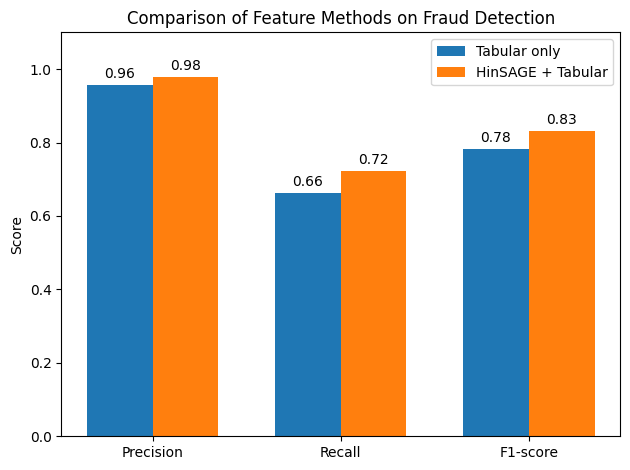

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def cm_to_y(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    y_true = [0]*tn + [0]*fp + [1]*fn + [1]*tp
    y_pred = [0]*tn + [1]*fp + [0]*fn + [1]*tp
    return y_true, y_pred

y_true_tabular, y_pred_tabular = cm_to_y(cm_tabular)
y_true_fusion, y_pred_fusion = cm_to_y(cm_fusion)

# Calculate metrics
precision_tabular = precision_score(y_true_tabular, y_pred_tabular)
recall_tabular = recall_score(y_true_tabular, y_pred_tabular)
f1_tabular = f1_score(y_true_tabular, y_pred_tabular)

precision_fusion = precision_score(y_true_fusion, y_pred_fusion)
recall_fusion = recall_score(y_true_fusion, y_pred_fusion)
f1_fusion = f1_score(y_true_fusion, y_pred_fusion)

# Plotting
labels = ['Precision', 'Recall', 'F1-score']
tabular_scores = [precision_tabular, recall_tabular, f1_tabular]
fusion_scores = [precision_fusion, recall_fusion, f1_fusion]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, tabular_scores, width, label='Tabular only')
bars2 = ax.bar(x + width/2, fusion_scores, width, label='HinSAGE + Tabular')

# Add text above bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

# Formatting
ax.set_ylabel('Score')
ax.set_title('Comparison of Feature Methods on Fraud Detection')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Check fraud label fusion model catch only
df_compare = pd.DataFrame({
    'y_true': y_test,
    'pred_fusion': y_pred_xgb_hinsage,
    'pred_tabular': y_pred_xgb
})

df_fusion_catch_only = df_compare[
    (df_compare['y_true'] == 1) &
    (df_compare['pred_fusion'] == 1) &
    (df_compare['pred_tabular'] == 0)
]

display(df_fusion_catch_only)

,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,fraud_label,Hour,Minute,Date,Day of Week,client_node,merchant_node
0,2016,3,15,294.05,Online Transaction,6759623715801000040,ONLINE,NaN,NaN,5311,NaN,1,11,12,2016-03-15,Tue,1890_0,6759623715801000040_ONLINE
1,2016,7,31,22.86,Online Transaction,6661973303171003879,ONLINE,NaN,NaN,5211,NaN,1,12,7,2016-07-31,Sun,885_1,6661973303171003879_ONLINE
2,2016,6,7,65.98,Online Transaction,3189517333335617109,ONLINE,NaN,NaN,5311,NaN,1,11,44,2016-06-07,Tue,1394_0,3189517333335617109_ONLINE
3,2016,10,20,8.23,Online Transaction,-3220758452254689706,ONLINE,NaN,NaN,5311,NaN,1,15,31,2016-10-20,Thu,1981_0,-3220758452254689706_ONLINE


In [ ]:
target_merchants = df_fusion_catch_only['merchant_node']

filtered_df = orig_df[orig_df['merchant_node'].isin(target_merchants)].copy()

result = (
    filtered_df
    .groupby('merchant_node')
    .agg(
        total_transactions=('fraud_label', 'size'),         
        fraud_transactions=('fraud_label', 'sum'),           
        fraud_rate=('fraud_label', lambda x: x.mean() * 100) 
    .reset_index()
    .sort_values(by='fraud_rate', ascending=False)          
)
)
# In kết quả
display(result)

,merchant_node,total_transactions,fraud_transactions,fraud_rate
0,-3220758452254689706_ONLINE,9,9,100.0
1,3189517333335617109_ONLINE,1,1,100.0
2,6661973303171003879_ONLINE,2,2,100.0
3,6759623715801000040_ONLINE,4,4,100.0
